In [1]:
import gym, math, tqdm, statistics as sts, numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Criando o ambiente
env_name = 'Acrobot-v1'
env = gym.make(env_name)

/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wasf84/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# Isso é para garantir o mesmo ambiente de execução toda vez.
seed_val = 369
env.seed(seed_val)
np.random.seed(seed_val)

/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [4]:
num_eps = 15000
epsilon, min_epsilon = 0.0, 0.1
learning_rate, min_learning_rate = 0.0, 0.2
discount_factor = 0.95
dec = 15

# Essa variável é apenas para discretizar a observação do ambiente.
discrete_st = (15, 15, 1, 1, 100, 1)
lower_st = [-1.0, -1.0, -1.0, -1.0, -12.57, -28.27]
upper_st = [1.0, 1.0, 1.0, 1.0, 12.57, 28.27]

qtable = np.zeros(discrete_st + (env.action_space.n, ))

In [5]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower_st[i])) / (upper_st[i] - lower_st[i])
        new_state = int(round((discrete_st[i] - 1) * stepsize))
        new_state = min(discrete_st[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def update_qtable(state, action, reward, new_state):
    # isso está no Google Colab da disciplina
    qtable[state][action] += learning_rate * (reward + discount_factor * np.max(qtable[new_state]) - qtable[state][action])

In [6]:
# TREINAMENTO
# ===================

# usado para plotar o gráfico de aprendizado
tr = []

for ep in tqdm.tqdm(range(num_eps)):
    current_state = discrete_state(env.reset())

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False
    
    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        action = choose_action(current_state)
        observation, reward, done, _ = env.step(action)
        new_state = discrete_state(observation)
        update_qtable(current_state, action, reward, new_state)
        current_state = new_state
        r.append(reward)
        # fim WHILE
        
    env.close()
    tr.append(sum(r))
    # fim FOR

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:50<00:00, 51.58it/s]


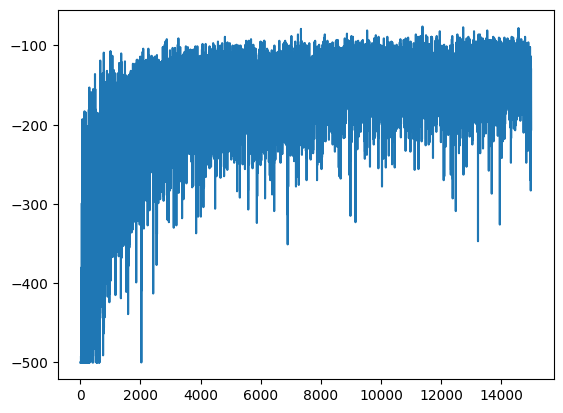

In [7]:
plt.plot(tr)

In [8]:
# AVALIAÇÃO
# ===================

tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):

    # ambiente a ser avaliado
    env_t = gym.make(env_name)

    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:

        # Renderizar os ultimos 5 episodios
        #if i >= (int(num_eps * 0.1) - 5):
            #env_t.render()

        action = np.argmax(qtable[cs])
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)
        # fim WHILE

    i += 1
    env_t.close()
    tr.append(sum(r))
    # fim FOR

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:22<00:00, 67.14it/s]


In [9]:
#plt.hist(tr)

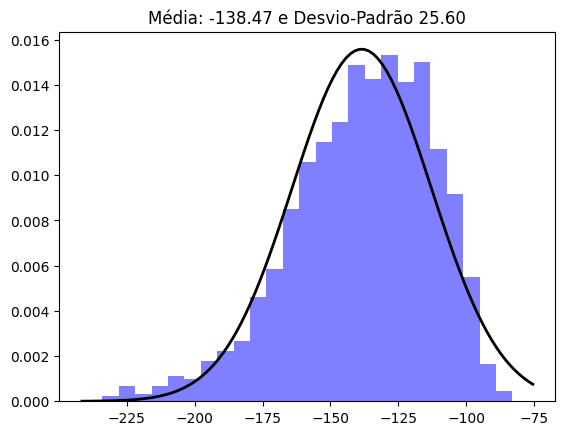

In [12]:
# Calcular o desvio-padrão da amostra

mu, std = norm.fit(tr)
plt.hist(tr, bins=25, density=True, alpha=0.5, color='b')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Média: {:.2f} e Desvio-Padrão {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()